<a href="https://colab.research.google.com/github/dtajiri/jupyter-notebooks/blob/master/Learning_To_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Model

### ***Disclaimer: The colab was ran locally due to limited RAM when connected to a hosted runtime

### path directory can be modified to run on viewer's local machine


### 1) Imports

In [ ]:
# Import dependencies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### 2) Download Dataset

In [ ]:
# Download the dataset located at https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip
# You can read about the features included in the dataset here: 
# https://www.microsoft.com/en-us/research/project/mslr/

# Load dataset
train = pd.read_csv('Downloads/MSLRWEB10K/Fold1/train.txt', sep=' ', header=None)
test = pd.read_csv('Downloads/MSLRWEB10K/Fold1/test.txt', sep=' ', header=None)
val = pd.read_csv('Downloads/MSLRWEB10K/Fold1/vali.txt', sep=' ', header=None)

# visualize raw data frame
train

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,2,qid:1,1:3,2:3,3:0,4:0,5:3,6:1,7:1,8:0,...,128:11089534,129:2,130:116,131:64034,132:13,133:3,134:0,135:0,136:0,NaN
1,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:2,130:124,131:64034,132:1,133:2,134:0,135:0,136:0,NaN
2,0,qid:1,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,128:3,129:1,130:124,131:3344,132:14,133:67,134:0,135:0,136:0,NaN
3,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:13,130:123,131:63933,132:1,133:3,134:0,135:0,136:0,NaN
4,1,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:5,129:7,130:256,131:49697,132:1,133:13,134:0,135:0,136:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,0,qid:29992,1:2,2:0,3:1,4:1,5:2,6:1,7:0,8:0.50000,...,128:7,129:2,130:13829,131:35302,132:21,133:8,134:0,135:0,136:0,NaN
723408,0,qid:29992,1:2,2:1,3:1,4:1,5:2,6:1,7:0.50000,8:0.50000,...,128:0,129:0,130:26074,131:35101,132:14,133:7,134:1,135:0,136:0,NaN
723409,0,qid:29992,1:2,2:2,3:2,4:2,5:2,6:1,7:1,8:1,...,128:11,129:2,130:2995,131:62170,132:4,133:8,134:0,135:0,136:0,NaN
723410,0,qid:29992,1:2,2:0,3:0,4:0,5:2,6:1,7:0,8:0,...,128:0,129:0,130:138,131:56419,132:4,133:3,134:0,135:0,136:0,NaN


### 3) Preprocess and evaluate the dataset

In [ ]:
# Create a dict to rename columns of the data frame
d = dict()
d[0] = 'relevance'
d[1] = 'qid'
for x in range(2,138):
    d[x]=f'{x-1}'

# change format of data so that table entries dont include the lables (i.e 'qid' and the feature number)

# train set
train.rename(columns=d,inplace = True)
train.drop(columns=train.columns[-1], axis=1,inplace=True)
for i in range(137):
  x = []
  for j in list(train.iloc[:, i+1]):
    x.append(j.split(':')[1])
  train.iloc[:, i+1] = x
    
# test set
test.rename(columns=d,inplace = True)
test.drop(columns=test.columns[-1], axis=1,inplace=True)
for i in range(137):
  x = []
  for j in list(test.iloc[:, i+1]):
    x.append(j.split(':')[1])
  test.iloc[:, i+1] = x 


# validation set
val.rename(columns=d,inplace = True)
val.drop(columns=val.columns[-1], axis=1,inplace=True)
for i in range(137):
    x = []
    for j in list(val.iloc[:, i+1]):
        x.append(j.split(':')[1])
    val.iloc[:, i+1] = x

In [ ]:
# To see the amount of queries in each dataset

train_groups = pd.DataFrame({'qid': train['qid'], 'relevance' :train['relevance']}).groupby('qid')
test_groups = pd.DataFrame({'qid': test['qid'], 'relevance' :test['relevance']}).groupby('qid')
val_groups = pd.DataFrame({'qid': val['qid'], 'relevance' :val['relevance']}).groupby('qid')
print('The amount of queries in the train dataset: ', len(pd.DataFrame({'qid': train['qid'], 'relevance' :train['relevance']}).groupby('qid').groups))
print('The amount of queries in the test dataset: ', len(test_groups.groups))
print('The amount of queries in the validation dataset: ', len(val_groups.groups),'\n')

print('* different queries have different amounts of documents related to it *')
print('The amount of documents associated with qid 1 in train dataset: ', len(train_groups.groups['1']))
print('The amount of documents associated with qid 16 in train dataset: ',len(train_groups.groups['16']))
print('The amount of documents associated with qid 31 in train dataset: ',len(train_groups.groups['31']))

qid_10045 = val[val.qid =='10045']
print('\n* As seen below, some queries have no documents that are relevant *')
display(qid_10045.sort_values(by = 'relevance').tail()) # sort lists the entries from lowest to highest

qid_10 = val[val.qid =='10']
print('\n* Compared to the query above, the query with qid 10 has documents that have relevance ranging from 0 - 4 *')
display(qid_10.sort_values(by = 'relevance')) # sort lists the entries from lowest to highest

The amount of queries in the train dataset:  6000
The amount of queries in the test dataset:  2000
The amount of queries in the validation dataset:  2000 

* different queries have different amounts of documents related to it *
The amount of documents associated with qid 1 in train dataset:  86
The amount of documents associated with qid 16 in train dataset:  106
The amount of documents associated with qid 31 in train dataset:  92

* As seen below, some queries have no documents that are relevant *


,relevance,qid,1,2,3,4,5,6,7,8,...,127,128,129,130,131,132,133,134,135,136
75480,0,10045,3,0,0,0,3,1,0,0,...,37,13,0,6447,11640,1,18,0,0,0
75481,0,10045,0,0,0,0,0,0,0,0,...,20,0,0,50217,9776,1,88,0,2,82.8
75482,0,10045,3,0,3,2,3,1,0,1,...,62,1,0,1185,45660,16,18,0,0,0
75484,0,10045,3,3,3,0,3,1,1,1,...,38,2,2,191,30773,18,118,0,0,0
75509,0,10045,3,0,1,0,3,1,0,0.333333,...,22,0,0,61604,25504,1,4,0,14,30.4161904761905



* Compared to the query above, the query with qid 10 has documents that have relevance ranging from 0 - 4 *


,relevance,qid,1,2,3,4,5,6,7,8,...,127,128,129,130,131,132,133,134,135,136
0,0,10,2,0,0,0,2,0.666667,0,0,...,45,1,0,117,55115,7,2,0,0,0
33,0,10,0,0,0,0,0,0,0,0,...,10,0,0,27378,2561,62,157,0,0,0
34,0,10,3,0,3,0,3,1,0,1,...,47,7,1,1890,34192,2,1,0,0,0
37,0,10,0,0,0,0,0,0,0,0,...,35,11,3,5145,61346,1,1,0,0,0
39,0,10,1,0,1,0,1,0.333333,0,0.333333,...,11,0,0,62543,34399,1,1,0,318,60.0168778961509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2,10,3,0,3,3,3,1,0,1,...,97,6,0,20177,33213,1,6,0,0,0
59,3,10,3,0,3,0,3,1,0,1,...,20,1896,1,21725,35216,1,1,5,0,0
73,4,10,3,0,3,0,3,1,0,1,...,30,1883,1,48645,35168,1,1,2241,426,30.1554670902879
23,4,10,3,0,3,0,3,1,0,1,...,34,1943,1,46900,34605,1,1,0,4,5.8


In [ ]:
# Define the X data and y labels for Linear Regression

X_train = train[train.columns[2:]]
y_train = train['relevance']
X_test = test[test.columns[2:]]
y_test = test['relevance']
X_val = val[val.columns[2:]]
y_val = val['relevance']

In [ ]:
# Convert to XGBoost Data Matrix for XGB LambdaMart Ranking model

XGB_training_data = xgb.DMatrix('Downloads/MSLRWEB10K/Fold1/train.txt')
XGB_testing_data = xgb.DMatrix('Downloads/MSLRWEB10K/Fold1/test.txt')
XGB_validation_data = xgb.DMatrix('Downloads/MSLRWEB10K/Fold1/vali.txt')

### 4) Build ranking model and test on validation set

###### Learning to Rank with Linear Regression

In [ ]:
# Fit Linear Regression model to data using sklearn
regr = LinearRegression()
regr.fit(X_train,y_train)
regr.score(X_train,y_train) #goodness of fit

# getting predictions for validation set
lin_reg_pred_val = regr.predict(X_val)

In [ ]:
# create functions to compute nDCG

def ndcg_at_k(truth, prediction, k=None):
    """Returns normalized Discounted Cumulative Gain
    Args:
        truth (1-D Array): list of relevance in true order
        prediction (1-D Array): list of relevance in predicted order
        k (int): nDCG calculated on first k entries, default = None
    Returns:
        ndcg (float): normalized Discounted Cumulative Gain score [0,1] at k"""
    truth = np.sort(truth)[::-1] #sort truth array from highest to lowest relevance
    k = min(len(prediction), k) #k will be the minimum of either the length of the data or use given k
    log_den = 1 / (np.log2(np.arange(1,k+1) + 1)) #create an array for dcg and idcg denominator
    idcg = np.sum(truth[:k] * log_den) #summation of truth value * log denominator array
    dcg = np.sum(prediction[:k] * log_den) #summation of predicted value * log denominator array
    
    return dcg/idcg #return nDCG

# function used to apply to all qid groups
def all_ndcg_at_k(group, k=None):
    truth = np.array(group.truth.tolist())
    prediction = np.array(group.sort_values(by = "predicted").truth.tolist())
    return ndcg_at_k(truth,prediction,k)

In [ ]:
lin_reg_pred_df = pd.DataFrame({'qid': val['qid'], 'truth' :y_val, 'predicted' : lin_reg_pred_val})
lin_reg_groups = lin_reg_pred_df.groupby('qid')
lin_reg_ndcg_score = lin_reg_groups.apply(all_ndcg_at_k, k=100) 
display(lin_reg_ndcg_score.head(10))
print('* NaN values are due to querries that have documents that are all 0 in the relevant scale *')

qid
10       0.516668
100      0.608987
1000     0.446300
10000    0.338311
10015    0.453043
10030    0.500000
10045         NaN
10060    0.687932
10075    0.490889
10090    0.168788
dtype: float64

* NaN values are due to querries that have documents that are all 0 in the relevant scale *


In [ ]:
# evaluating how well model does on validation set
mse = mean_squared_error(lin_reg_pred_val, y_val)
print(f'The Mean Squared Error is: {mse}')
print(f'The average of all the qid group nDCGs:', np.nanmean(lin_reg_ndcg_score)) 
print('* average nDCG scores increase as k increase *')

The Mean Squared Error is: 0.6051755110970498
The average of all the qid group nDCGs: 0.47256748855540126
* average nDCG scores increase as k increase *


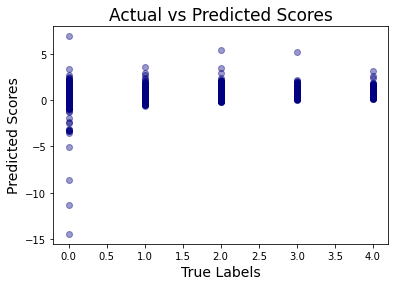

From the above graph, we can tell that:
	 • documents with higher relevance have smaller predicted score ranges (range not including outliers)
	 • predicted scores range from around -14 to 7
	 • documents with relevance of 0 has the most variation/outliers in predicted score


In [ ]:
plt.scatter(x=y_val, y=lin_reg_pred_val, c = 'navy', alpha = .4)

plt.xlabel('True Labels', fontsize=14)
plt.ylabel('Predicted Scores', fontsize=14)
plt.title('Actual vs Predicted Scores', fontsize = 17)

plt.show()

print('From the above graph, we can tell that:')
print('\t \u2022 documents with higher relevance have smaller predicted score ranges (range not including outliers)')
print('\t \u2022 predicted scores range from around -14 to 7')
print('\t \u2022 documents with relevance of 0 has the most variation/outliers in predicted score')

###### Learning to Rank with XGBoost LambdaRank (Pair-wise Ranking) and LambdaMart (List-wise Ranking) 

In [ ]:
# LamdaRank (Pair-wise Ranking)

# Define the model and fit to data 
lambdaRank_model = xgb.train(
    {'objective':'rank:pairwise',
     'max_depth': 2,
     'eta': 0.1,
     'seed': 279,
     'tree_method': 'approx'},
    XGB_training_data,
    num_boost_round = 5)

# Predict scores
lr_pred = lambdaRank_model.predict(XGB_validation_data)

In [ ]:
# Create data frame of qid, true labels, and predicted scores
lr_pred_df = pd.DataFrame({'qid': val['qid'], 'truth':y_val, 'predicted': lr_pred})

# group data by qid
lr_groups = lr_pred_df.groupby('qid')

# calculate nDCG on all qid groups
lr_ndcg_score = lr_groups.apply(all_ndcg_at_k, k=100) 
display(lr_ndcg_score.head(10))
print('The Mean Squared Error is: ', mean_squared_error(lr_pred, y_val))
print('The average of all the qid group nDCGs:', np.nanmean(lr_ndcg_score)) 

qid
10       0.531915
100      0.578286
1000     0.513512
10000    0.410372
10015    0.397349
10030    0.630930
10045         NaN
10060    0.699835
10075    0.533585
10090    0.195328
dtype: float64

The Mean Squared Error is:  0.6962045418899816
The average of all the qid group nDCGs: 0.49277894921586435


In [ ]:
# LamdaMart (List-wise Ranking)

# Define the model and fit to data 
lambdaMart_model = xgb.train(
    {'objective':'rank:ndcg',
     'max_depth': 2,
     'eta': 0.1,
     'seed': 279,},
    XGB_training_data,
    num_boost_round = 5)

# Predict scores
lm_pred = lambdaMart_model.predict(XGB_validation_data)

In [ ]:
# Create data frame of qid, true labels, and predicted scores
lm_pred_df = pd.DataFrame({'qid': val['qid'], 'truth':y_val, 'predicted': lm_pred})
lm_groups = lm_pred_df.groupby('qid')
lm_ndcg_score = lm_groups.apply(all_ndcg_at_k, k=100) 
display(lm_ndcg_score.head(10))
print('The Mean Squared Error is: ', mean_squared_error(lm_pred, y_val))
print('The average of all the qid group nDCGs:', np.nanmean(lm_ndcg_score)) 

qid
10       0.538541
100      0.598432
1000     0.532945
10000    0.407622
10015    0.390917
10030    0.630930
10045         NaN
10060    0.682414
10075    0.462021
10090    0.246491
dtype: float64

The Mean Squared Error is:  0.690297870335471
The average of all the qid group nDCGs: 0.5038547445714483


In [ ]:
#Since LambdaMart produced the best nDCG score, we'll continue to use the model

# Define the model with different eta and fit to data 
# adjusting eta allows for correction of over/under fitting
lambdaMart_model_small_eta = xgb.train(
    {'objective':'rank:ndcg',
     'max_depth': 2,
     'eta': 0.0000001,
     'seed': 279,},
    XGB_training_data,
    num_boost_round = 5)

# Predict scores
lm_pred_small_eta = lambdaMart_model_small_eta.predict(XGB_validation_data)

In [ ]:
# Create data frame of qid, true labels, and predicted scores
lm_pred_small_eta_df = pd.DataFrame({'qid': val['qid'], 'truth':y_val, 'predicted': lm_pred_small_eta})

# group data by qid
lm_small_eta_groups = lm_pred_small_eta_df.groupby('qid')

# calculate nDCG on all qid groups
lm_small_eta_ndcg_score = lm_small_eta_groups.apply(all_ndcg_at_k, k=100) 
display(lm_small_eta_ndcg_score.head(10))
print('The Mean Squared Error is: ', mean_squared_error(lm_pred_small_eta, y_val))
print('The average of all the qid group nDCGs:', np.nanmean(lm_small_eta_ndcg_score)) 

qid
10       0.546666
100      0.592464
1000     0.551302
10000    0.402560
10015    0.395734
10030    0.630930
10045         NaN
10060    0.746701
10075    0.518688
10090    0.314994
dtype: float64

The Mean Squared Error is:  0.7205877279315275
The average of all the qid group nDCGs: 0.5206019427409502


### 5) Evaluate model performance

###### Out of the 3 models shown above, the XGBoost LambdaMart model performed the best on the validation set. Therefore, I will be evaluating that model's performance on the test set.

In [ ]:
# Predict scores using the small eta model
final_pred = lambdaMart_model_small_eta.predict(XGB_testing_data)

# Create data frame of qid, true labels, and predicted scores
final_pred_df = pd.DataFrame({'qid': test['qid'], 'truth':y_test, 'predicted': final_pred})

# group data by qid
final_groups = final_pred_df.groupby('qid')

# calculate nDCG on all qid groups
final_ndcg_score = final_groups.apply(all_ndcg_at_k, k=100) 
display(final_ndcg_score.head(10))
print('The Mean Squared Error is: ', mean_squared_error(final_pred, y_test))
print('The average of all the qid group nDCGs:', np.nanmean(final_ndcg_score))

qid
10003    0.458293
10018         NaN
1003     0.542167
10033    0.433920
10048    0.406465
10063    0.375651
10078    0.388718
10093    0.517295
10108    0.166358
10123    0.497726
dtype: float64

The Mean Squared Error is:  0.7253292595164605
The average of all the qid group nDCGs: 0.5167650855540964


# Discussion

**Explanation of thought process and reasoning behind models and evaluation metrics used**

There were 3 models that I tested for this project, which are linear regression for point-wise ranking, lambdaRank for pair-wise ranking, and lambdaMart for list-wise ranking. There are many reasons why I decided to evaluate 3 different models. These some of the reason are that:
- Linear regression is a commonly used model in ML and is a model I'm very familiar with, so it was interesting to see it's effectiveness in learning to rank.
- Decision trees (XGBoost's lambdaMart) are also very popular among supervised learning methods and I wanted to familiarize myself with XGBoost's library.
- I wanted to explore and gain more experience in deep learning models, which is why I decided to use XGBoost's lambdaRank (a neural network)
- The final model I decided on using for testing was lambdaMart due to it having performed the best in terms of nDCG score on the validation set.

I chose 2 different metrics to evaluate my models: Mean Squared Error (MSE) and Normalized Discounted Cumulative Gain (nDCG).
- I decided to use MSE because linear regression works to minimize MSE, therefore I wanted to see how well the model performed in terms of minimizing it's loss function compared to the minimizing MSE performance of the other models. In term's of minimizing MSE the linear regression model did the best, but in terms of average nDCG score among the query groups it produced the worst result.
- An nDCG score ranges from 0 to 1 (1 means that the rankings were 100% accurate and the list returned was the optimal list, whereas 0 means the model performed terribly). The reason for chooosing nDCG as a metric of evaluation is that it is a better determination of success in terms of learning to rank. It takes into consideration that we care more about the difference in top ranking documents and positions rather than the bottom part of the ranking list. I decided on using the nDCG@k metric since it takes into consideration only the k (k in this case was 100) top documents, which is better in terms of comparing how well the models did among query groups of all different sizes.
- Compare to MSE, nDCG is a better metric due to the fact that MSE measures accuracy depending on the distance between predicted scores and true ranking position rather than the diffrence in predicted rank and true rank. Predicted scores don't have as much meaning to the objective as the predicted rank does. Therefore, the metric I put more emphasis on improving was the nDCG score.

In terms of final model (lambdaMart/List-wise ranking) performace, my model produced a 51.7% accuracy. This accuracy is dependent on only the top 100 ranked documents for each query. I believe good accuracy and performace is dependent on the situation. If was wanted to produce the exact same ranking list given, then 51.7% wouldn't be as ideal. However, I believe that everyone wouldn't have the exact same ranking list in mind when searching a query. For better words, what one person deems a relevant document might not be the same as what another deems relevant. Because of this, I believe it is okay to have a little room for error in terms of nDCG score. Given this, I think performance accuracy of 60%-80% would be ideal and my model doesn't quite hit the mark.

If I had more time, I would have wanted to explore the linear regression model a little more. Compared to the the neural network and decision tree it didn't too horribly with an accuracy score of 47.3% on the validation set. In order to improve the model, I would have tested for multicollinearity by looking at the feature's Variance Inflation Factor. I'd also want to analyzed the feature's p-values to determine their significance.

Id also want to explore and learn more in depth about XGBoost's model parameters and how they could help me increase accuracy. For example, the 'eta' parameter used above for the lambdaMart and lambdaRank models is used for ensuring that there isn't over/under fitting, which is why my performace increased when I lowered the size of the parameter.

I would also have wanted to try these models all the different data files available. I was only able to train, validate, and test on the files in folder 1, but it'd be interesting to see if the performance would change if the model were trained and tested on a different data set.

**Other features that could provide to be of help towards the performace of the three models:**

I believe that user_id would be a great feature to include, this is because relevancey could depend on the user that is searching the query. I think along with user_id another feature that could help would be data on previously searched queries. If a user has searched a query and didn't find a document fit to their needs, they would likely rephrase the query. Having data on previously search queries could offer a way to ensure that the user doesnt keep seeing the same top documents even after rephrasing their query. 

Access to features like query_text, title_text, body_text, and document_url could also prove to be helpful. If given access to features, I could put more emphasis on certain words in the query. For example, words like "who", "what", "why", "when", and "where" provide more importance to ranking results than words like 'a', 'the', 'it', etc. By putting emphasis on certain words in the query text, we can determine a score on how often it appears in the title, body, or url. We could also determine how soon in the document that the words are seen. Url information is also very important, especially domain name. If creating a search engine, we wouldn't want to list dangerous documents at the top even though they might perfectly match the query.

### 8) Please submit your colab by sharing it with: cmaon@oreilly.com and rlandry@oreilly.com
